In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Coastal Data System - Waves (Mooloolaba) 01-2017 to 06 - 2019.csv to Coastal Data System - Waves (Mooloolaba) 01-2017 to 06 - 2019.csv


In [4]:
df = pd.read_csv("Coastal Data System - Waves (Mooloolaba) 01-2017 to 06 - 2019.csv")

In [5]:
print(df.head())

          Date/Time      Hs   Hmax      Tz      Tp  Peak Direction    SST
0  01/01/2017 00:00 -99.900 -99.90 -99.900 -99.900           -99.9 -99.90
1  01/01/2017 00:30   0.875   1.39   4.421   4.506           -99.9 -99.90
2  01/01/2017 01:00   0.763   1.15   4.520   5.513            49.0  25.65
3  01/01/2017 01:30   0.770   1.41   4.582   5.647            75.0  25.50
4  01/01/2017 02:00   0.747   1.16   4.515   5.083            91.0  25.45


In [6]:
# Deleting NaN values
df.replace(-99.90, np.nan, inplace=True)
df.drop('Date/Time', axis=1, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,Hs,Hmax,Tz,Tp,Peak Direction,SST
0,0.763,1.15,4.520,5.513,49.0,25.65
1,0.770,1.41,4.582,5.647,75.0,25.50
2,0.747,1.16,4.515,5.083,91.0,25.45
3,0.718,1.61,4.614,6.181,68.0,25.45
4,0.707,1.34,4.568,4.705,73.0,25.50


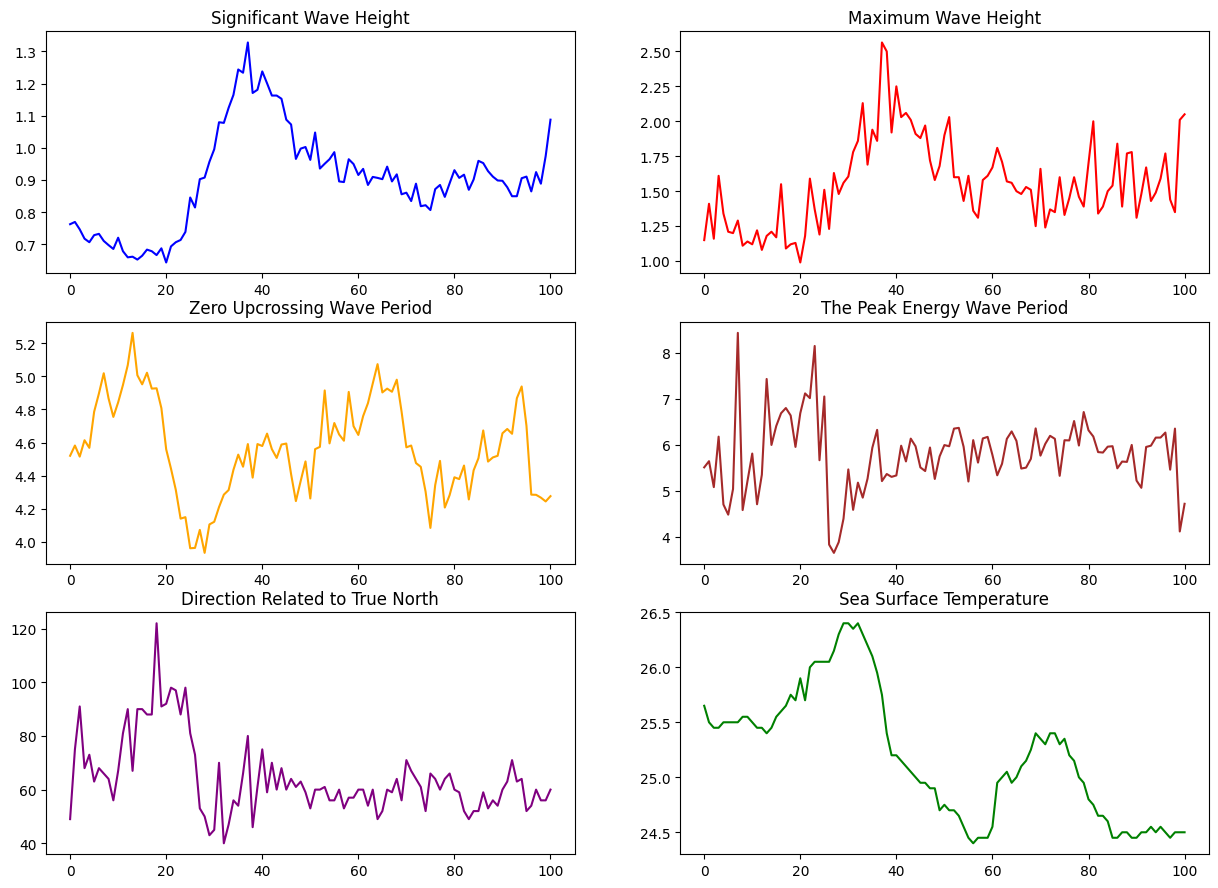

In [7]:
df_graph = df.loc[0:100]

plt.figure(figsize=(15,22))
plt.subplot(6,2,1)
plt.plot(df_graph['Hs'], color='blue')
plt.title('Significant Wave Height')

plt.subplot(6,2,2)
plt.plot(df_graph['Hmax'], color='red')
plt.title('Maximum Wave Height')

plt.subplot(6,2,3)
plt.plot(df_graph['Tz'], color='orange')
plt.title('Zero Upcrossing Wave Period')

plt.subplot(6,2,4)
plt.plot(df_graph['Tp'], color='brown')
plt.title('The Peak Energy Wave Period')

plt.subplot(6,2,5)
plt.plot(df_graph['Peak Direction'], color='purple')
plt.title('Direction Related to True North')

plt.subplot(6,2,6)
plt.plot(df_graph['SST'], color='green')
plt.title('Sea Surface Temperature')
plt.show();

In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43454 entries, 0 to 43453
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Hs              43454 non-null  float64
 1   Hmax            43454 non-null  float64
 2   Tz              43454 non-null  float64
 3   Tp              43454 non-null  float64
 4   Peak Direction  43454 non-null  float64
 5   SST             43454 non-null  float64
dtypes: float64(6)
memory usage: 2.0 MB
None


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Hs,43454.0,1.237799,0.528608,0.294,0.839,1.130,1.544,4.257
Hmax,43454.0,2.090125,0.897640,0.510,1.410,1.900,2.600,7.906
Tz,43454.0,5.619685,0.928533,3.076,4.981,5.530,6.166,10.921
Tp,43454.0,9.011972,2.390107,2.720,7.292,8.886,10.677,21.121
Peak Direction,43454.0,98.626594,24.275165,5.000,85.000,101.000,116.000,358.000
SST,43454.0,23.949641,2.231022,19.800,21.900,23.950,26.050,28.650


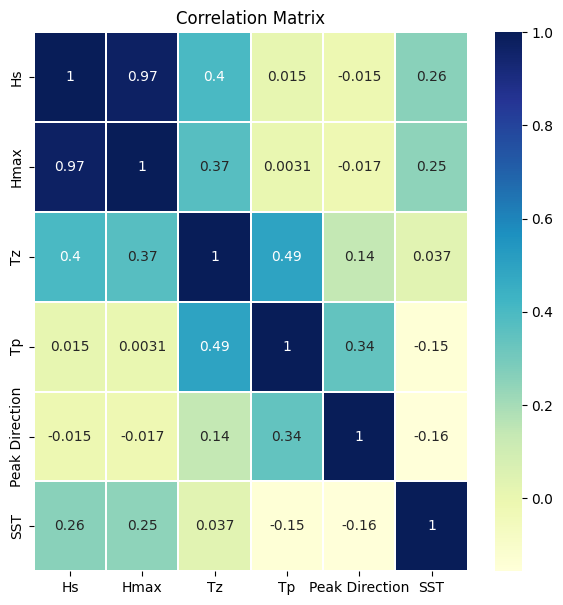

In [10]:
plt.figure(figsize=(7,7))
sns.heatmap(df.corr(), linewidth=.1, annot=True, cmap='YlGnBu')
plt.title('Correlation Matrix')
plt.show();

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(df)
print('Shape of the scaled data matrix: ', data.shape)

Shape of the scaled data matrix:  (43454, 6)


In [13]:
train = data[:42000,]
test = data[42000: ,]
print('Shape of train data: ', train.shape)
print('Shape of test data: ', test.shape)

Shape of train data:  (42000, 6)
Shape of test data:  (1454, 6)


In [14]:
def prepare_data(data):
    databatch = 30
    x_list = []
    y_list = []

    for i in range(len(data)-databatch-1):
        x_list.append(data[i:i+databatch])
        y_list.append(data[i+databatch+1])

    X_data = np.array(x_list)
    X_data = np.reshape(X_data, (X_data.shape[0], X_data.shape[2], X_data.shape[1]))
    y_data = np.array(y_list)

    return X_data, y_data

In [15]:
X_train, y_train = prepare_data(train)
X_test, y_test = prepare_data(test)
print('X_train Shape : ', X_train.shape, 'y_train shape :', y_train.shape)
print('X_test Shape  : ', X_test.shape, ' y_test shape  :', y_test.shape)

X_train Shape :  (41969, 6, 30) y_train shape : (41969, 6)
X_test Shape  :  (1423, 6, 30)  y_test shape  : (1423, 6)


In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

def lstm_model(x_data, y_data, num_epochs, batch_size, learning_rate):

    model = Sequential()

    model.add(LSTM(32, input_shape=(x_data.shape[1], x_data.shape[2]), return_sequences=True))

    model.add(LSTM(16, return_sequences=True))

    model.add(Dropout(0.2))

    model.add(LSTM(10))

    model.add(Dense(6))

    optimizer = Adam(learning_rate=learning_rate)

    # Compiling the model
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])

    # Fitting the model
    history = model.fit(x_data, y_data, validation_split=0.25, epochs=num_epochs, batch_size=batch_size)

    return model, history

In [20]:
history = lstm_model(X_train, y_train, num_epochs=15, batch_size=200, learning_rate=.001)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.0412 - mean_squared_error: 0.0412 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 2/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 3/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 4/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 5/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 6/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 7/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_lo

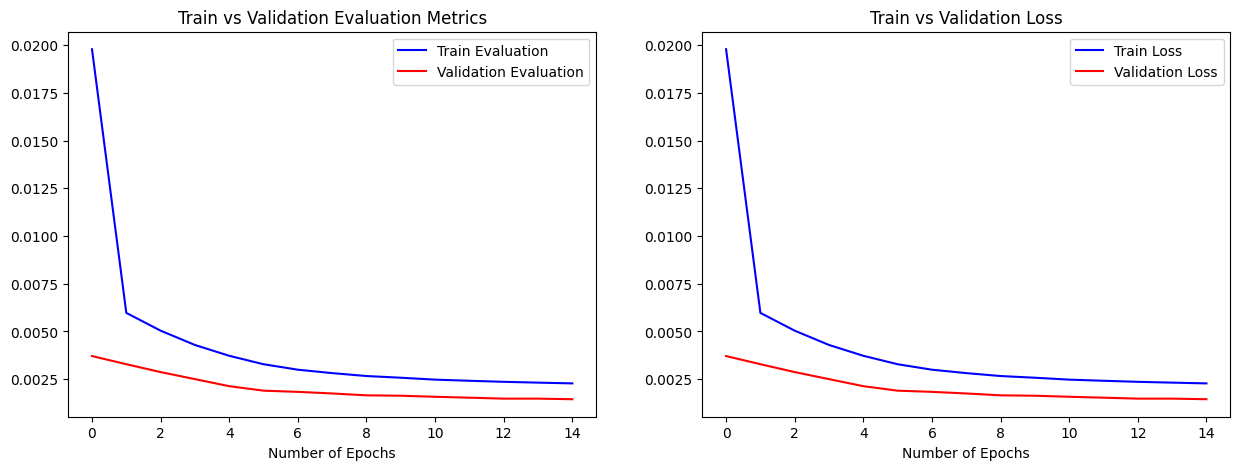

In [21]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history[1].history['mean_squared_error'], color='blue', label='Train Evaluation')
plt.plot(history[1].history['val_mean_squared_error'], color='red', label='Validation Evaluation')
plt.title('Train vs Validation Evaluation Metrics')
plt.xlabel('Number of Epochs')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history[1].history['loss'], color='blue', label='Train Loss')
plt.plot(history[1].history['val_loss'], color='red', label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Number of Epochs')
plt.legend()
plt.show();

In [22]:

def predicting(data, y_real):
    predicted_data = history[0].predict(data)

    predicted_data = scaler.inverse_transform(predicted_data)
    y_real = scaler.inverse_transform(y_real)

    return predicted_data, y_real

train_prediction, y_train = predicting(X_train, y_train)
test_prediction, y_test = predicting(X_test, y_test)

1312/1312 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [23]:
import math
from sklearn.metrics import mean_squared_error

def examine_rmse(y_data, predicted_data):
    Score_Hs = math.sqrt(mean_squared_error(y_data[:,0], predicted_data[:,0]))
    Score_Hmax = math.sqrt(mean_squared_error(y_data[:,1], predicted_data[:,1]))
    Score_Tz = math.sqrt(mean_squared_error(y_data[:,2], predicted_data[:,2]))
    Score_Tp = math.sqrt(mean_squared_error(y_data[:,3], predicted_data[:,3]))
    Score_Dir = math.sqrt(mean_squared_error(y_data[:,4], predicted_data[:,4]))
    Score_SST = math.sqrt(mean_squared_error(y_data[:,5], predicted_data[:,5]))

    print('RMSE_Hs       : ', Score_Hs)
    print('RMSE_Hmax     : ', Score_Hmax)
    print('RMSE_Tz       : ', Score_Tz)
    print('RMSE_Tp       : ', Score_Tp)
    print('RMSE_Direction: ', Score_Dir)
    print('RMSE_SST      : ', Score_SST)

print('Trainin Data Errors')
print(examine_rmse(y_train, train_prediction),'\n')
print('Test Data Errors')
print(examine_rmse(y_test, test_prediction))

Trainin Data Errors
RMSE_Hs       :  0.0981953742249505
RMSE_Hmax     :  0.25865186191421724
RMSE_Tz       :  0.3167522557453583
RMSE_Tp       :  1.3195154950825752
RMSE_Direction:  13.612331577598937
RMSE_SST      :  0.19977635557157056
None 

Test Data Errors
RMSE_Hs       :  0.08511843184114326
RMSE_Hmax     :  0.24438504048622783
RMSE_Tz       :  0.33135987766393427
RMSE_Tp       :  1.9464950535623797
RMSE_Direction:  14.25759729245281
RMSE_SST      :  0.18740885926082476
None


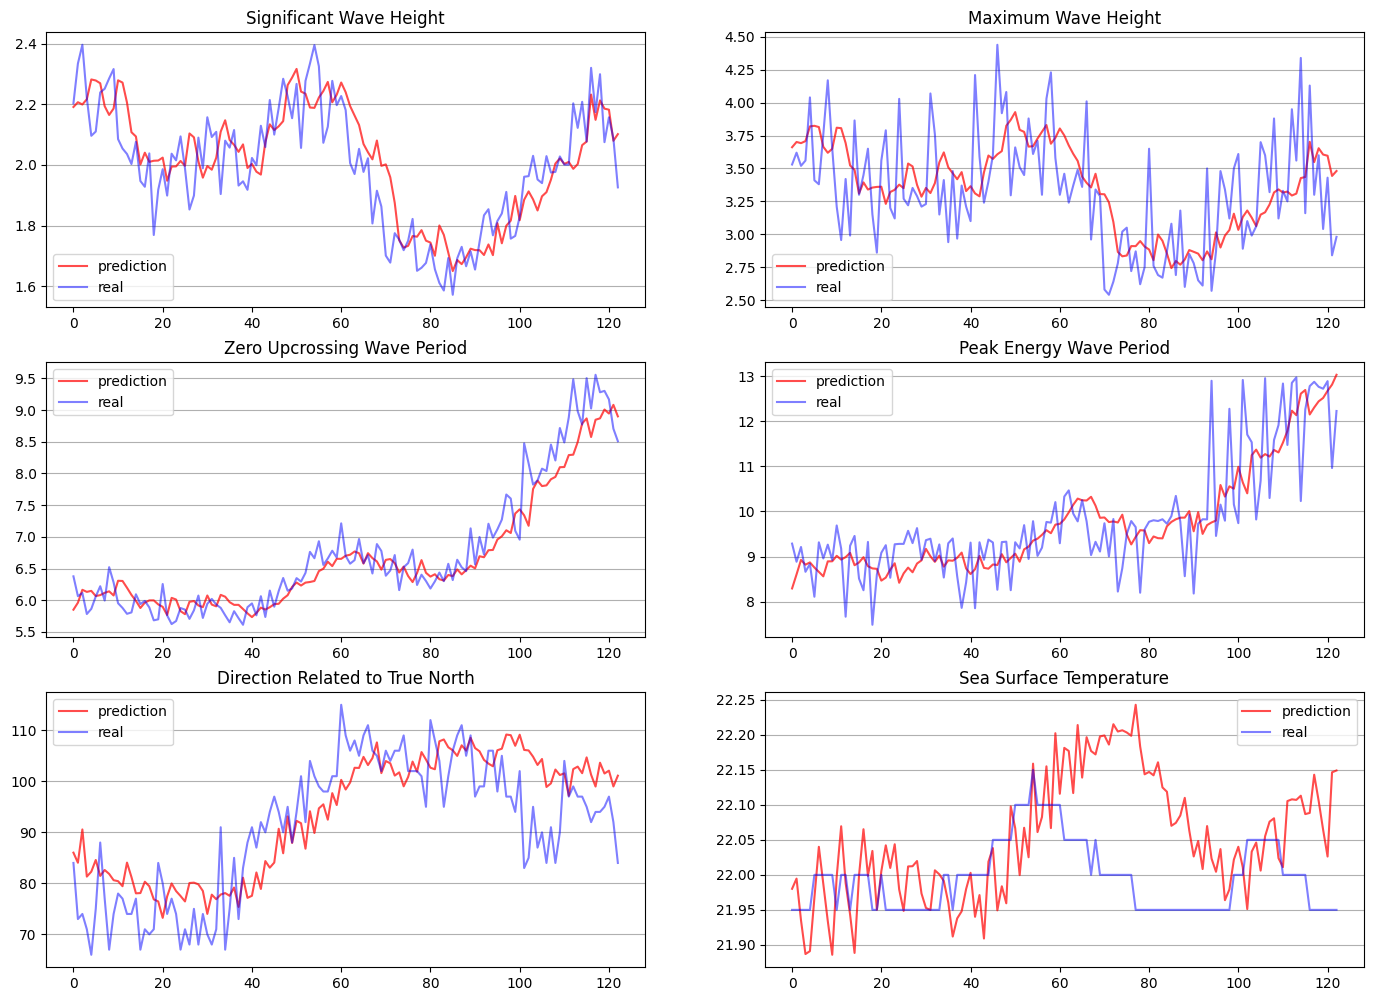

In [25]:
plt.figure(figsize=(17,25))


plt.subplot(6,2,1)
plt.plot(test_prediction[1300:,0], color='red', alpha=0.7, label='prediction')
plt.plot(y_test[1300:,0], color='blue', alpha=0.5, label='real')
plt.title('Significant Wave Height')
plt.legend()
plt.grid(visible=True, axis='y')

plt.subplot(6,2,2)
plt.plot(test_prediction[1300:,1], color='red', alpha=0.7, label='prediction')
plt.plot(y_test[1300:,1], color='blue', alpha=0.5, label='real')
plt.title('Maximum Wave Height')
plt.legend()
plt.grid(visible=True, axis='y')

plt.subplot(6,2,3)
plt.plot(test_prediction[1300:,2], color='red', alpha=0.7, label='prediction')
plt.plot(y_test[1300:,2], color='blue', alpha=0.5, label='real')
plt.title('Zero Upcrossing Wave Period')
plt.legend()
plt.grid(visible=True, axis='y')

plt.subplot(6,2,4)
plt.plot(test_prediction[1300:,3], color='red', alpha=0.7, label='prediction')
plt.plot(y_test[1300:,3], color='blue', alpha=0.5, label='real')
plt.title('Peak Energy Wave Period')
plt.legend()
plt.grid(visible=True, axis='y')

plt.subplot(6,2,5)
plt.plot(test_prediction[1300:,4], color='red', alpha=0.7, label='prediction')
plt.plot(y_test[1300:,4], color='blue', alpha=0.5, label='real')
plt.title('Direction Related to True North')
plt.legend()
plt.grid(visible=True, axis='y')

plt.subplot(6,2,6)
plt.plot(test_prediction[1300:,5], color='red', alpha=0.7, label='prediction')
plt.plot(y_test[1300:,5], color='blue', alpha=0.5, label='real')
plt.title('Sea Surface Temperature')
plt.legend()
plt.grid(visible=True, axis='y')
plt.show();